# Derive Pituitary ROI from Whole-Brain MRI

## Imports

In [65]:
# Utilities
import os, sys, time, glob, re

import pandas as pd
import numpy as np
import torch
import SimpleITK as sitk


# Pre-processing transforms
from fastai.basics import ItemTransform
from monai.transforms import (
    AddChanneld,
    CenterSpatialCropd,
    Compose,
    NormalizeIntensityd,
    Spacingd,
    SpatialPadd,
    ToTensord,
)

# Models
from monai.networks.nets import VNet, UNet

# Viz
from matplotlib import colors
import matplotlib.pyplot as plt
%matplotlib inline

## Models

In [6]:
# Define model arch
ensemble_models = {
    "UNET3D_dice_loss": UNet(
                    dimensions=3,
                    in_channels=1,
                    out_channels=2,
                    channels=(16, 32, 64, 128, 256),
                    strides=(2, 2, 2, 2),
                    num_res_units=2,
                    dropout=0.0,
                ),

    "VNET_dice_loss": VNet(
                spatial_dims=3,
                in_channels=1,
                out_channels=2,
            ),
    
    "CONDSEG_dice_loss": UNet(
                    dimensions=3,
                    in_channels=3,
                    out_channels=2,
                    channels=(16, 32, 64, 128, 256),
                    strides=(2, 2, 2, 2),
                    num_res_units=2,
                    dropout=0.0,
                )
}

# Load pretrained weights
for model_name, model_arch in ensemble_models.items():
    loc = torch.load(f'ensemble_models/{model_name}/model.pth')
    model_arch.load_state_dict(loc['model'])

# Load Data

- Data source: LONI Imaging & Data Archive (https://ida.loni.usc.edu/login.jsp). 
- Datasets: ABIDE, ABVIB, ADNI1_Complete_1Yr_1.5T, AIBL, ICMB, and PPMI.

In [7]:
# Data Source
dset_src = '/gpfs/data/oermannlab/private_data/DeepPit/PitMRdata'

# Load example files for inference
inference_df = pd.read_csv("inference_example.csv")
display(inference_df)

# Note we have one example from each dataset
mr_paths = inference_df.fn.values
print("MR paths: ", *mr_paths, sep="\n")

# for conditional segmentation models, the model input also contains an atlas MR and segmentation
example_atlas = {
    'image': f'{dset_src}/samir_labels/50373-50453/50437/MP-RAGE/2000-01-01_00_00_00.0/S165191/ABIDE_50437_MRI_MP-RAGE_br_raw_20120830214425874_S165191_I329201_corrected_n4.nii',
    'label': f'{dset_src}/samir_labels/50373-50453/50437/seg.nii'
}

,fn,imputedSeq,sz,px,sp,dir
0,ABIDE/ABIDE_1/50412/MP-RAGE/2000-01-01_00_00_00.0/S164292,MPR,"(106, 256, 256)",16-bit signed integer,"(1.4, 1.0, 1.0)","(1, 0, 0, 0, -1, 0, 0, 0, 1)"
1,ABVIB/ABVIB/3830/MPRAGE/2012-06-18_11_46_49.0/S341930,MPR,"(256, 256, 192)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
2,ADNI/ADNI1_Complete_1Yr_1.5T/ADNI/023_S_0139/MPR-R__GradWarp__B1_Correction__N3__Scaled/2007-02-09_09_44_27.0/S26343,MPR,"(192, 192, 160)",32-bit float,"(1.26, 1.25, 1.19)","(0, 0, 1, 0, 1, 0, -1, 0, 0)"
3,AIBL/AIBL/338/MPRAGE_SAG_ISO_p2_ND/2012-10-06_11_32_11.0/S231118,MPR,"(256, 256, 176)",16-bit unsigned integer,"(1.0, 1.0, 1.0)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"
4,ICMB/ICBM/UTHC_1098/MPRAGE_T1_AX_0.8_mm_TI-780/2009-03-13_13_01_09.0/S68959,MPR,"(220, 320, 208)",16-bit unsigned integer,"(0.8, 0.8, 1.0)","(1, 0, 0, 0, 1, 0, 0, 0, 1)"
5,PPMI/PPMI/3505/MPRAGEadni/2010-12-23_10_50_52.0/S189286,MPR,"(288, 288, 170)",16-bit unsigned integer,"(0.92, 0.92, 1.2)","(0, 0, -1, 1, 0, 0, 0, -1, 0)"


MR paths: 
ABIDE/ABIDE_1/50412/MP-RAGE/2000-01-01_00_00_00.0/S164292
ABVIB/ABVIB/3830/MPRAGE/2012-06-18_11_46_49.0/S341930
ADNI/ADNI1_Complete_1Yr_1.5T/ADNI/023_S_0139/MPR-R__GradWarp__B1_Correction__N3__Scaled/2007-02-09_09_44_27.0/S26343
AIBL/AIBL/338/MPRAGE_SAG_ISO_p2_ND/2012-10-06_11_32_11.0/S231118
ICMB/ICBM/UTHC_1098/MPRAGE_T1_AX_0.8_mm_TI-780/2009-03-13_13_01_09.0/S68959
PPMI/PPMI/3505/MPRAGEadni/2010-12-23_10_50_52.0/S189286


# Pre-process

SITK: N4 bias correct, re-orient to LAS coordinates. Note: Bias correction takes ~20s per input. To save time, our workflow was to save the result of this pre-processing step once over all the raw inputs.

MONAI: transform to standard voxel spacing, pixel intensities, center crop to standard dimensions. On-the-fly.

In [8]:
def read_dcm(fn):
    """IO for reading .dcm files given path to folder"""
    dcms = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(fn)
    if len(dcms) == 1: dcms = dcms[0]   
    im = sitk.ReadImage(dcms, sitk.sitkFloat32)
    return im

def read_nii(fn):
    """IO for reading .nii files given path to folder"""
    if not fn.endswith(".nii"):
        niis = [f for f in os.listdir(fn) if f.endswith(".nii") and not f.startswith("._")]
        nii   = niis[0]
        im = sitk.ReadImage(f"{fn}/{nii}", sitk.sitkFloat32)    
    else:
        im = sitk.ReadImage(fn, sitk.sitkFloat32)
    return im

def n4_bias_correct(mr_path, do_write=False):
    """ Perform N4 bias correction. Input: path to folder with .dcms or .niis. """
    start = time.time()
    
    # Read in image
    try:
        inputImage = read_nii(mr_path)
    except:
        inputImage = read_dcm(mr_path) 

    # Mask the head to estimate bias
    maskImage = sitk.OtsuThreshold(inputImage, 0, 1, 200)

    # Set corrector
    corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrector.SetMaximumNumberOfIterations([3] * 3)
    corrected_image = corrector.Execute(inputImage, maskImage)

    # LAS coordinates
    corrected_image = sitk.DICOMOrient(inputImage, "LAS")
    
    # write image
    if do_write:
        corrected_fn = f"{mr_path}/corrected_n4.nii"
        sitk.WriteImage(corrected_image, corrected_fn)

    elapsed = time.time() - start
    print(f"Elapsed: {elapsed:0.2f} s")
    
    return corrected_image

class UndoDict(ItemTransform):
    """Convert dictionary to tuple """
    split_idx = None

    def __init__(self, keys=["image"]):
        self.keys = keys
        
    def encodes(self, d):
        item = tuple(d[key] for key in self.keys)
        # for condseg, 3-ch input
        item = torch.cat(item, dim=0)
        return item

    def __str__(self):
        return f"UndoDict({self.keys})"
    
def get_inference_transforms(keys, sp=(1.5,1.5,1.5), sz=(96,96,96), do_condseg = False):    
    """Preprocess inputs to standard voxel spacing, pixel intensity, center crop to standard dimensions"""
    
    # Z-scale intensity values in image (not labels)
    image_keys = [k for k in keys if "image" in k]
    
    # nearest neighbor interpolation for labels
    interp_mode = tuple(["bilinear" if "image" in k else "nearest" for k in keys])
        
    return Compose([
        Spacingd(keys, pixdim=sp, mode = interp_mode),
        NormalizeIntensityd(image_keys, nonzero=True, channel_wise=False),
        AddChanneld(keys),
        SpatialPadd(keys, spatial_size=sz, method="symmetric", mode="constant"),
        CenterSpatialCropd(keys, roi_size=sz),
        ToTensord(keys),
        UndoDict(keys),
    ])

# sitk obj and np array have different index conventions
def sitk2np(obj): return np.swapaxes(sitk.GetArrayFromImage(obj), 0, 2)
def np2sitk(arr): return sitk.GetImageFromArray(np.swapaxes(arr, 0, 2))

def torch2sitk(t): return sitk.GetImageFromArray(torch.transpose(t, 0, 2))
def sitk2torch(o): return torch.transpose(torch.tensor(sitk.GetArrayFromImage(o)), 0, 2)

In [9]:
# Optional: save the results of this step as time-intensive
n4_las_images = [n4_bias_correct(f"{dset_src}/{mr_path}") for mr_path in mr_paths]

Elapsed: 25.96 s
Elapsed: 24.39 s
Elapsed: 9.05 s
Elapsed: 36.11 s
Elapsed: 34.08 s
Elapsed: 28.56 s


In [11]:
# the atlas keys are only used for CONDSEG. As a toy example, we re-use the same atlas for each input.
# However, during training, the atlas is randomly assigned for each input. 
inputsd  = [
    {
        "image": sitk2np(im), 
        "atlas_image": sitk2np(read_nii(example_atlas["image"])),
        "atlas_label": sitk2np(read_nii(example_atlas["label"]))
    } 
    for im in n4_las_images
]

preproc_inputs         = get_inference_transforms(keys = ("image",))(inputsd)
condseg_preproc_inputs = get_inference_transforms(keys = ("image","atlas_image", "atlas_label"), do_condseg=True)(inputsd)

print("UNET/VNET input shape: ", preproc_inputs[0].shape, ". CONDSEG input shape: ", condseg_preproc_inputs[0].shape)

UNET/VNET input shape:  torch.Size([1, 96, 96, 96]) . CONDSEG input shape:  torch.Size([3, 96, 96, 96])


# Inference

Post-process: For each model's binary segmentation prediction, we keep the largest connected component. Our final output is the majority vote among the ensembled models.

In [12]:
# source sitk 36_Microscopy_Colocalization_Distance_Analysis.html
def get_largest_connected_component(binary_seg):
    """Returns largest connnected component of the predicted binary segmentation."""
    # connected components in sitkSeg
    labeled_seg = sitk.ConnectedComponent(binary_seg)

    # re-order labels according to size (at least 1_000 pixels = 10x10x10)
    labeled_seg = sitk.RelabelComponent(labeled_seg, minimumObjectSize=1000, sortByObjectSize=True)

    # return segm of largest label
    binary_seg = labeled_seg == 1
    
    return binary_seg

In [13]:
# each item in the list is the model's preds
all_outputs = []

for model_name, model_arch in ensemble_models.items():
    
    # get pre-processed inputs
    inputs = preproc_inputs if model_name != "CONDSEG_dice_loss" else condseg_preproc_inputs
    inputs = torch.stack(inputs, dim=0)
    
    # apply model to the 6 example inputs (one from each dset)
    model_arch.eval()
    with torch.no_grad():
        preds = model_arch(inputs).cpu()
        
    # keep largest connected component for each model prediction (model pred probs => binary seg => lcc)
    lcc = [get_largest_connected_component(torch2sitk(pred.argmax(0).byte())) for pred in preds]
    all_outputs.append(lcc)
    
# get majority vote for each input
def get_votes(i):
    """For example input i, returns a list of votes (ie each model's binary seg prediction)"""
    return [lcc[i] for lcc in all_outputs]

labelForUndecidedPixels = 0
majority_votes = [sitk.LabelVoting(get_votes(i), labelForUndecidedPixels) for i in range(len(preproc_inputs))]

In [25]:
# print number of nonzero elements in mask
for input_idx in range(6):
    nonzero_majority = len(torch.nonzero(sitk2torch(majority_votes[input_idx])))
    nonzero_indiv    =  [len(torch.nonzero(sitk2torch(all_outputs[model_idx][input_idx]))) for model_idx in range(3)]
    print(f"Ensemble ROI sz: {nonzero_majority:6d}. Indiv vote sizes: {nonzero_indiv}.")

Ensemble ROI sz:   9938. Indiv vote sizes: [9626, 10126, 10222].
Ensemble ROI sz:  11304. Indiv vote sizes: [10661, 11766, 11556].
Ensemble ROI sz:   5771. Indiv vote sizes: [5531, 5578, 6341].
Ensemble ROI sz:   9532. Indiv vote sizes: [9529, 9528, 9507].
Ensemble ROI sz:  12689. Indiv vote sizes: [12876, 11665, 13773].
Ensemble ROI sz:   8024. Indiv vote sizes: [7834, 8561, 7219].


### Viz inputs and outputs

In [91]:
def myshow(img, title=None, margin=0.05, dpi=80 ):
    nda = sitk.GetArrayFromImage(img)
    spacing = img.GetSpacing()
    
    
    if nda.ndim == 3:
        # fastest dim, either component or x
        c = nda.shape[-1]
        
        # the the number of components is 3 or 4 consider it an RGB image
        if not c in (3,4):
            nda = nda[nda.shape[0]//2,:,:]
    
    elif nda.ndim == 4:
        c = nda.shape[-1]
        
        if not c in (3,4):
            raise Runtime("Unable to show 3D-vector Image")
            
        # take a z-slice
        nda = nda[nda.shape[0]//2,:,:,:]
            
    ysize = nda.shape[0]
    xsize = nda.shape[1]
   
    
    # Make a figure big enough to accomodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = figure(figsize=figsize, dpi=dpi)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], ysize*spacing[0], 0)
    
    t = ax.imshow(nda,extent=extent,interpolation=None)
    
    if nda.ndim == 2:
        t.set_cmap("gray")
    
    if(title):
        plt.title(title)

In [93]:
a = get_votes(i)
a

[<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f55e9f60960> >,
 <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f55e9f60e70> >,
 <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7f55e9f23030> >]

In [98]:
def myshow(img):
    nda = sitk.GetArrayFromImage(img)
    plt.imshow(nda)

In [104]:
mask2bbox(sitk2torch(get_votes(i)[0]))

tensor([30, 62, 33, 55, 45, 61])

In [116]:
b = sitk.LabelToRGB(get_votes(i)[0])
c = sitk2torch(b)[45]

d = sitk.LabelToRGB(get_votes(i)[1])
e = sitk2torch(b)[45]

In [118]:
pink= [255,105,180]
green = [0,255,0]
gold = [255,215,0]

In [124]:
sitk.LabelOverlay(image=b, labelImage=d,
opacity=0.5, backgroundValue = -1.0, colormap = pink+green+gold)

RuntimeError: Exception thrown in SimpleITK LabelOverlay: /tmp/SimpleITK/Code/Common/include/sitkDualMemberFunctionFactory.hxx:193:
sitk::ERROR: Pixel type: vector of 8-bit unsigned integer is not supported in 3D byN3itk6simple23LabelOverlayImageFilterE

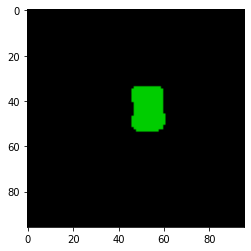

In [114]:
plt.imshow(c)

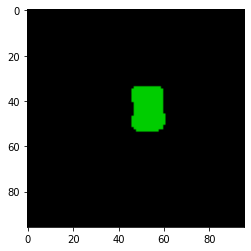

In [121]:
plt.imshow(e)

In [89]:
# ROI bounding box
def mask2bbox(mask):
    """Returns bounding box coordinates of binary mask"""
    k = torch.any(torch.any(mask, dim=0), dim=0) # 0 -> 1,2 -> 1 -> 2 left
    j = torch.any(torch.any(mask, dim=0), dim=1) # 0 -> 1,2 -> 2 -> 1 left
    i = torch.any(torch.any(mask, dim=1), dim=1) # 1 -> 0,2 -> 0 -> 0 left
    
    imin, imax = torch.where(i)[0][[0, -1]]
    jmin, jmax = torch.where(j)[0][[0, -1]]
    kmin, kmax = torch.where(k)[0][[0, -1]]
    
    # inclusive indices
    return torch.tensor([imin, imax+1, jmin, jmax+1, kmin, kmax+1])

def get_mid_idx(bbox, is_mask=False):
    """Returns the center coordinates of the bounding box"""
    if is_mask:
        bbox = mask2bbox(bbox)
       
    mid0     = (bbox[0] + bbox[1])//2        
    mid1     = (bbox[2] + bbox[3])//2
    mid2     = (bbox[4] + bbox[5])//2

    return mid0, mid1, mid2

def get_binary_cmap(color, bg="black"):
    """Returns binary color map """
    return colors.ListedColormap([bg, color])

def additive_blending(fig, ax, label, label_color, indiv_segs, color_list, slice_idx, axis_idx):
    """
    Additive blending of colors associated with each binary mask
    Source: https://cosmiccoding.com.au/tutorials/additive
    """
    # Draw the empty axis, which we use as a base.
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buffer = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8)
    first = buffer.astype(np.int16).reshape(h, w, -1) #int16 so we dont overflow
    first[first[:, :, -1] == 0] = 0 # Set transparent pixels to 0

    # Draw label and label color
    ax.clear(); ax.axis('off')
    ax.imshow(np.rot90(np.take(label, slice_idx, axis=axis_idx)), alpha = 0.5, cmap=get_binary_cmap(label_color))
    fig.canvas.draw()
    img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).astype(np.int16).reshape(h, w, -1)
    img[img[:, :, -1] == 0] = 0
    first += img # Add these particles to the main layer
        
    # Draw indiv segs with their color
    for indiv_seg, c in zip(indiv_segs, color_list):
        ax.clear(); ax.axis('off')
        ax.imshow(np.rot90(np.take(indiv_seg, slice_idx, axis=axis_idx)), alpha=0.5, cmap=get_binary_cmap(c))        
        fig.canvas.draw()
        img = np.frombuffer(fig.canvas.buffer_rgba(), np.uint8).astype(np.int16).reshape(h, w, -1)
        img[img[:, :, -1] == 0] = 0
        first += img # Add these particles to the main layer
    
    first = np.clip(first, 0, 255) # Clip buffer back to int8 range

    ax.clear()
    plt.axis("off")
    ax.imshow(first.astype(np.uint8), aspect='auto')

def imshows(ims):
    """Viz function to show ims"""

    # grid
    nrow = len(ims)
    ncol = 6

    fig, axes = plt.subplots(nrow, ncol, figsize=(
        ncol * 3, nrow * 3), facecolor='white')
    
    # plot
    for i, im_dict in enumerate(ims):
        im          = im_dict["image"].detach().squeeze().cpu().numpy()
        label       = im_dict["label"].detach().squeeze().cpu().numpy()
        label_color = im_dict["label_color"]
        fname       = im_dict["fname"]
        indiv_segs  = [seg.detach().squeeze().cpu().numpy() for seg in im_dict["indiv_segs"]]
        color_list  = im_dict["color_list"]
        
        # get bbox
        bbox = mask2bbox(torch.tensor(label))
        mids = get_mid_idx(bbox)
        for axis_idx in range(3):
            slice_idx = mids[axis_idx]

            # plot image 0-2 (MR + final output overlay)
            ax  = axes[i, 0+axis_idx]
            #ax.set_title(f"{fname} Slice {slice_idx} (Axis {axis_idx})")
            ax.imshow(np.rot90(np.take(im, slice_idx, axis=axis_idx)), cmap=plt.cm.gray)
            ax.imshow(np.rot90(np.take(label, slice_idx, axis=axis_idx)), alpha=0.2, cmap=get_binary_cmap(label_color))
            ax.axis("off")
                
            # plot labels 3-5 (final output + indiv model binary segs)
            ax        = axes[i, 3+axis_idx]
            ax.axis("off")
            
            additive_blending(fig, ax, label, label_color, indiv_segs, color_list, slice_idx, axis_idx)
            
#             # show indiv segs
#             for indiv_seg, c in zip(indiv_segs,color_list):
#                 ax.imshow(np.rot90(np.take(indiv_seg, slice_idx, axis=axis_idx)), alpha=0.5, cmap=get_binary_cmap(c))
#             #fig.colorbar(im_show, ax=ax)
            
#             # show ensemble seg
#             #im_show = ax.imshow(np.rot90(np.take(label, slice_idx, axis=axis_idx)))
#             ax.imshow(np.rot90(np.take(label, slice_idx, axis=axis_idx)), alpha = 0.5, cmap=get_binary_cmap(label_color))
            
        # print fname
        axes[i,0].set_title(f"{fname}")
        axes[i,3].set_title(f"Ensemble Seg")

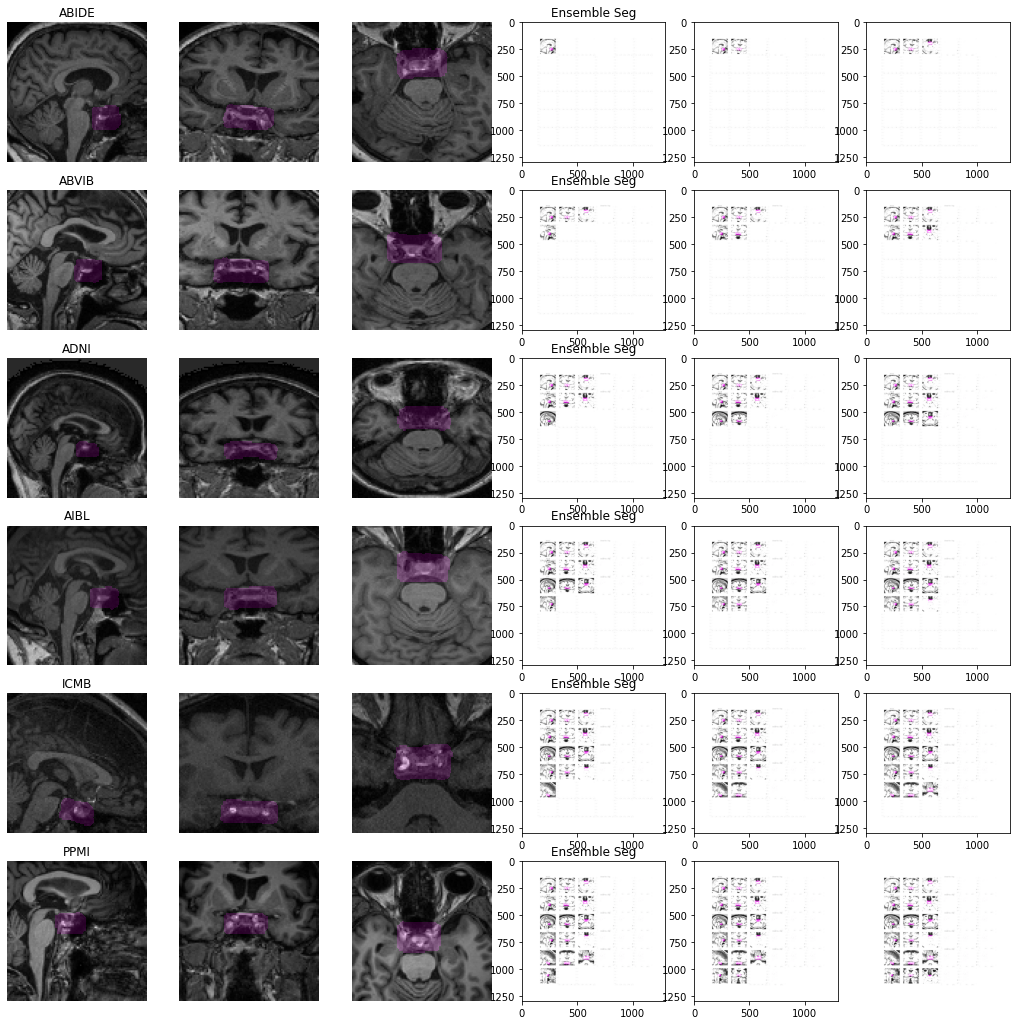

In [90]:
# test on one
to_imshow = []

for i in range(len(preproc_inputs)):
    # get dset name
    input_fn = mr_paths[i]
    dset_name = input_fn[:input_fn.index("/")]
    
    # get input and output
    input_im   = preproc_inputs[i]
    output_seg = sitk2torch(majority_votes[i])
    output_color = "m" 
    
    # get indiv predictions (show each in its own color, yellow, green, cyan)
    indiv_segs = [sitk2torch(bin_seg) for bin_seg in get_votes(i)]
    color_list = ['y', 'g', 'c']
    
    to_imshow.append({"image": input_im, "label": output_seg, "label_color": output_color, "fname": dset_name, 
                      "indiv_segs": indiv_segs, "color_list": color_list})

imshows(to_imshow)

# End